In [1]:
import numpy as np
import pandas as pd
import random
import nltk
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import graphviz
import matplotlib.pyplot as plt
from sklearn import svm
from gensim.models import Word2Vec
import os
from nltk.stem.porter import *
from nltk.corpus import stopwords
from stringprep import in_table_a1
import string
import csv
import math
import json

plt.rcParams["figure.figsize"] = (10,10)


      
              



In [2]:
import string
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *
# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def get_tokens(text):
  # turn document into lowercase
  lowers = text.lower()
  # remove punctuations
  no_punctuation = lowers.translate(remove_punctuation_map)
  # tokenize document
  tokens = nltk.word_tokenize(no_punctuation)
  # remove stop words
  filtered = [w for w in tokens if not w in stopwords.words('english')]
  # stemming process
  stemmed = []
  for item in filtered:
      stemmed.append(stemmer.stem(item))
  # final unigrams
  return stemmed


def get_dict(fpath):
    dictionary = {}
    with open(fpath, "r") as f:
        for i, word in enumerate(f):
            dictionary[word.strip()] = i
    return dictionary
Dict = get_dict("dictionary.txt")
# with open('dictionary.txt', 'r') as dict:
#   for line in dict:
#     l = line.strip('\n')
#     Dict.append(l)

def remove(list):
  nlist = []
  for text in list:
    ntext = ""
    for token in get_tokens(text):
      if token in Dict:
        ntext += token + " "
    nlist.append(ntext)
  return nlist

In [3]:


class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [4]:
# Load Data

root_folder='.'
train_data = pd.read_csv("news-train.csv")
test_data = pd.read_csv("news-test.csv")

data_folder_name='data'
glove_filename='glove.6B.100d.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename))

from gensim.scripts.glove2word2vec import glove2word2vec

word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

train_data

/var/folders/tt/y2sg92b14ll03_4m7_0y9zfh0000gn/T/ipykernel_29105/1385991116.py:16: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [5]:
# Shuffle Data

train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [6]:
# X/Y Split

train_data_x = train_data["Text"]
trainX = remove(train_data["Text"])
train_data_y = train_data["Category"]

test_data_x = test_data["Text"]
# testX = test_data_x
# test_x = test_data_x

In [7]:
vectorizer = CountVectorizer()
train_data_x = vectorizer.fit_transform(train_data_x)
# test_data_x = vectorizer.transform(test_data_x)

print(train_data_x.shape)
# print(test_data_x.shape)

(1490, 24746)


In [8]:
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors

# model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
# word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
vectorizer = Word2VecVectorizer(model)


trainX = vectorizer.fit_transform(trainX)
test_data_x = vectorizer.transform(test_data_x)
print(trainX.shape)

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 1490
Numer of samples with no words found: 0 / 735
(1490, 100)


In [9]:
# # Decision Tree
# dt = None

# def train_dt(depths, train_data_x, train_data_y):
#     global dt
#     train_acc_all = []
#     val_acc_all = []

#     kf = KFold(n_splits = 5)

#     for d in depths:
#         print(f"Depth: {d}")
#         train_acc = []
#         val_acc = []
#         for train_index, val_index in kf.split(train_data_x):
#             train_x = train_data_x[train_index,:]
#             val_x = train_data_x[val_index,:]

#             train_y = train_data_y[train_index]
#             val_y = train_data_y[val_index]

#             dt = tree.DecisionTreeClassifier(max_depth=d, criterion="gini")
#             dt.fit(train_x, train_y)

#             train_acc.append(dt.score(train_x, train_y))
#             val_acc.append(dt.score(val_x, val_y))

#         avg_tacc = np.mean(np.array(train_acc))
#         avg_vacc = np.mean(np.array(val_acc))

#         print(f"Avg Train Acc: {avg_tacc}\tAvg Val Acc: {avg_vacc}")

#         train_acc_all.append(avg_tacc)
#         val_acc_all.append(avg_vacc)

#     return train_acc_all, val_acc_all
    

# # depths = [10, 25, 50, 75, 100, 125, 150]
# dt_depths = [x for x in range(1,152,10)]
# dt_tacc, dt_vacc = train_dt(dt_depths, train_data_x, train_data_y)

# plt.plot(dt_depths, dt_tacc, marker='.', label="Training accuracy")
# plt.plot(dt_depths, dt_vacc, marker='.', label="Validation accuracy")
# plt.xlabel('Depth of tree')
# plt.ylabel('Accuracy')
# plt.legend()

In [10]:
# dot_data = tree.export_graphviz(dt, max_depth=3, filled=True, rounded=True, feature_names=vectorizer.get_feature_names(), class_names=list(set(list(train_data["Category"]))))
# graph = graphviz.Source(dot_data)
# graph

Depth: 10
RF Std Train Acc: 0.0	RF Std Val Acc: 0.0
RF Avg Train Acc: 1.0	RF Avg Val Acc: 0.9563758389261745
SVM Std Train Acc: 0.010067114093959717	SVM Std Val Acc: 0.03691275167785235
SVM Avg Train Acc: 0.9899328859060403	SVM Avg Val Acc: 0.9899328859060403
RF Std Train Acc: 0.009491366190423444	RF Std Val Acc: 0.031159705318085283
RF Avg Train Acc: 0.9932885906040269	RF Avg Val Acc: 0.9250559284116332
SVM Std Train Acc: 0.012249112206752368	SVM Std Val Acc: 0.027824033476135917
SVM Avg Train Acc: 0.9880453020134229	SVM Avg Val Acc: 0.9880453020134229
RF Std Train Acc: 0.011954035658091848	RF Std Val Acc: 0.03001433526845356
RF Avg Train Acc: 0.9904362416107382	RF Avg Val Acc: 0.9295302013422819
SVM Std Train Acc: 0.01160177574323768	SVM Std Val Acc: 0.027427740123577696
SVM Avg Train Acc: 0.9886744966442952	SVM Avg Val Acc: 0.9886744966442952
RF Std Train Acc: 0.011448957330841782	RF Std Val Acc: 0.02640544459045142
RF Avg Train Acc: 0.9902924256951102	RF Avg Val Acc: 0.931927133269

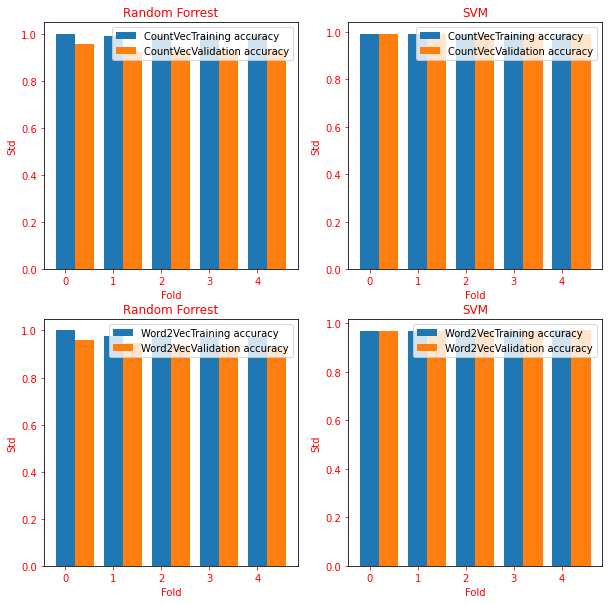

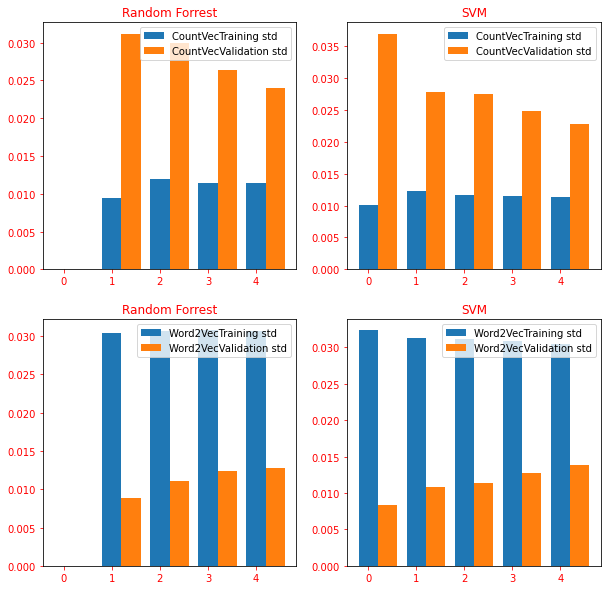

In [17]:
# Random Forest
rf = None
dt = None
def train_rf(depths, train_data_x, train_data_y):
    global rf
    global dt
    rf_train_acc_all = []
    rf_val_acc_all = []
    svm_train_acc_all = []
    svm_val_acc_all = []
    rf_train_std_all = []
    rf_val_std_all = []
    svm_train_std_all = []
    svm_val_std_all = []

    kf = KFold(n_splits = 5)

    for d in depths:
        print(f"Depth: {d}")
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_data_x):
            train_x = train_data_x[train_index,:]
            val_x = train_data_x[val_index,:]

            train_y = train_data_y[train_index]
            val_y = train_data_y[val_index]

            rf = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=1)
            rf.fit(train_x, train_y)

            train_acc.append(rf.score(train_x, train_y))
            val_acc.append(rf.score(val_x, val_y))

            avg_tacc = np.mean(np.array(train_acc))
            avg_vacc = np.mean(np.array(val_acc))
            std_tacc = np.std(np.array(train_acc))
            std_vacc = np.std(np.array(val_acc))
            print(f"RF Std Train Acc: {std_tacc}\tRF Std Val Acc: {std_vacc}")
            print(f"RF Avg Train Acc: {avg_tacc}\tRF Avg Val Acc: {avg_vacc}")

            rf_train_acc_all.append(avg_tacc)
            rf_val_acc_all.append(avg_vacc)
            rf_train_std_all.append(std_tacc)
            rf_val_std_all.append(std_vacc)
    

            dt = svm.SVC()
            dt.fit(train_x, train_y)
            
            train_acc.append(dt.score(train_x, train_y))
            val_acc.append(dt.score(val_x, val_y))

            avg_tacc = np.mean(np.array(train_acc))
            avg_vacc = np.mean(np.array(train_acc))
            std_tacc = np.std(np.array(train_acc))
            std_vacc = np.std(np.array(val_acc))
            print(f"SVM Std Train Acc: {std_tacc}\tSVM Std Val Acc: {std_vacc}")
            print(f"SVM Avg Train Acc: {avg_tacc}\tSVM Avg Val Acc: {avg_vacc}")

            svm_train_acc_all.append(avg_tacc)
            svm_val_acc_all.append(avg_vacc)
            svm_train_std_all.append(std_tacc)
            svm_val_std_all.append(std_vacc)

    return rf_train_acc_all, rf_val_acc_all, svm_train_acc_all, svm_val_acc_all, rf_train_std_all, rf_val_std_all, svm_train_std_all, svm_val_std_all
    

# depths = [10, 25, 50, 75, 100, 125, 150]

trainx = [train_data_x, trainX]
fig, axs = plt.subplots(2, 2)
fig, ax = plt.subplots(2, 2)
for i in range(2):
    rf_depths = [10]
    rf_tacc, rf_vacc, svm_tacc, svm_vacc, rf_tstd, rf_vstd, svm_tstd, svm_vstd= train_rf(rf_depths, trainx[i], train_data_y)
    z = "Word2Vec"
    if(i == 0):
        z = "CountVec"

    x = np.arange(5)
    axs[i, 0].bar(x, rf_tacc, width = 0.4, label=z + "Training accuracy")
    axs[i, 0].bar(x + 0.4, rf_vacc, width = 0.4, label=z + "Validation accuracy")
    axs[i, 0].set_title('Random Forrest', color='red')
    axs[i, 0].xaxis.label.set_color('red')
    axs[i, 0].yaxis.label.set_color('red')
    axs[i, 0].tick_params(axis='x', colors='red')
    axs[i, 0].tick_params(axis='y', colors='red')
    axs[i, 0].legend()


    axs[i, 1].bar(x, svm_tacc, width = 0.4, label=z + "Training accuracy")
    axs[i, 1].bar(x + 0.4, svm_vacc, width = 0.4, label= z + "Validation accuracy")
    axs[i, 1].xaxis.label.set_color('red')
    axs[i, 1].yaxis.label.set_color('red')
    axs[i, 1].tick_params(axis='x', colors='red')
    axs[i, 1].tick_params(axis='y', colors='red')
    axs[i, 1].set_title('SVM', color='red')
    axs[i, 1].legend()

    ax[i, 0].bar(x, rf_tstd, width = 0.4, label=z + "Training std")
    ax[i, 0].bar(x + 0.4, rf_vstd, width = 0.4, label=z + "Validation std")
    ax[i, 0].set_title('Random Forrest', color='red')
    ax[i, 0].xaxis.label.set_color('red')
    ax[i, 0].yaxis.label.set_color('red')
    ax[i, 0].tick_params(axis='x', colors='red')
    ax[i, 0].tick_params(axis='y', colors='red')
    ax[i, 0].legend()


    ax[i, 1].bar(x, svm_tstd, width = 0.4, label=z + "Training std")
    ax[i, 1].bar(x + 0.4, svm_vstd, width = 0.4, label= z + "Validation std")
    ax[i, 1].xaxis.label.set_color('red')
    ax[i, 1].yaxis.label.set_color('red')
    ax[i, 1].tick_params(axis='x', colors='red')
    ax[i, 1].tick_params(axis='y', colors='red')
    ax[i, 1].set_title('SVM', color='red')
    ax[i, 1].legend()
    i += 1

for ax in axs.flat:
    ax.set(xlabel='Fold', ylabel='Accuracy')
for axs in axs.flat:
    axs.set(xlabel='Fold', ylabel='Std')

plt.savefig('Chart', edgecolor="none")



In [12]:
# # Gradient Boosting Trees

# gbt = None

# def train_gbt(depths, train_data_x, train_data_y):
#     global gbt
#     train_acc_all = []
#     val_acc_all = []

#     kf = KFold(n_splits = 5)

#     for d in depths:
#         print(f"Depth: {d}")
#         train_acc = []
#         val_acc = []
#         for train_index, val_index in kf.split(train_data_x):
#             train_x = train_data_x[train_index,:]
#             val_x = train_data_x[val_index,:]

#             train_y = train_data_y[train_index]
#             val_y = train_data_y[val_index]

#             gbt = GradientBoostingClassifier(n_estimators=25, criterion="squared_error", max_depth=d)
#             gbt.fit(train_x, train_y)

#             train_acc.append(gbt.score(train_x, train_y))
#             val_acc.append(gbt.score(val_x, val_y))

#         avg_tacc = np.mean(np.array(train_acc))
#         avg_vacc = np.mean(np.array(val_acc))

#         print(f"Avg Train Acc: {avg_tacc}\tAvg Val Acc: {avg_vacc}")

#         train_acc_all.append(avg_tacc)
#         val_acc_all.append(avg_vacc)

#     return train_acc_all, val_acc_all
    

# gbt_depths = [10, 25, 50, 75, 100, 125, 150]
# gbt_tacc, gbt_vacc = train_gbt(gbt_depths, train_data_x, train_data_y)

# plt.plot(gbt_depths, gbt_tacc, marker='.', label="Training accuracy")
# plt.plot(gbt_depths, gbt_vacc, marker='.', label="Validation accuracy")
# plt.xlabel('Depth of tree')
# plt.ylabel('Accuracy')
# plt.legend()

In [13]:
ret = dt.predict(test_data_x)

In [14]:
id_pred = list(zip(list(test_data["ArticleId"]), list(ret)))
id_pred = pd.DataFrame()
id_pred["ArticleId"] = test_data["ArticleId"]
id_pred["Pred"] = list(ret)
id_pred.set_index("ArticleId")

,Pred
ArticleId,
568,politics
178,sport
258,tech
1200,entertainment
1789,entertainment
...,...
827,entertainment
1936,politics
2039,politics


In [15]:
# # SVM
# dt = None

# def train_dt(depths, train_data_x, train_data_y):
#     global dt
#     train_acc_all = []
#     val_acc_all = []

#     kf = KFold(n_splits = 5)

#     for d in depths:
#         print(f"Fold: {kf}")
#         train_acc = []
#         val_acc = []
#         for train_index, val_index in kf.split(train_data_x):
#             train_x = train_data_x[train_index,:]
#             val_x = train_data_x[val_index,:]

#             train_y = train_data_y[train_index]
#             val_y = train_data_y[val_index]

#             dt = svm.SVC()
#             dt.fit(train_x, train_y)

#             train_acc.append(dt.score(train_x, train_y))
#             val_acc.append(dt.score(val_x, val_y))

#             avg_tacc = np.mean(np.array(train_acc))
#             avg_vacc = np.mean(np.array(val_acc))

#             print(f"Avg Train Acc: {avg_tacc}\tAvg Val Acc: {avg_vacc}")

#             train_acc_all.append(avg_tacc)
#             val_acc_all.append(avg_vacc)

#     return train_acc_all, val_acc_all
    
# kf = [1,2,3,4,5]
# # depths = [10, 25, 50, 75, 100, 125, 150]
# dt_depths = [x for x in range(1)]
# dt_tacc, dt_vacc = train_dt(dt_depths, trainX, train_data_y)



# x = np.arange(5)
# plt.bar(x, dt_tacc, width = 0.4, label="Training accuracy")
# plt.bar(x + 0.4, dt_vacc, width = 0.4, label="Validation accuracy")
# plt.xlabel('Depth of tree')
# plt.ylabel('Accuracy')
# plt.legend()

In [16]:
id_pred.to_csv("labels.csv", header=False, index=False)